In [41]:
%matplotlib inline

In [42]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "3"

from pathlib import Path
import torch
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.encoder import Encoder
from bliss.catalog import TileCatalog
from matplotlib import pyplot as plt

In [43]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path="../../bliss/conf", version_base=None):
    cfg = compose("base_config")

encoder: Encoder = instantiate(cfg.encoder)
encoder.load_state_dict(torch.load("../../data/pretrained_models/clahed_logged_2percent.pt"))
encoder.eval()
encoder.cuda()

simulator = instantiate(cfg.simulator)

torch.set_grad_enabled(False)

## One bright (easily detected) star at various positions

Compare samples with independent and dependent tiling

In [44]:
loc_grid_size = 3
loc_replicates = 20
n = loc_grid_size * loc_replicates
n_sources = torch.zeros(n, 20, 20, dtype=torch.long)
n_sources[:, 10, 10] = 1
locs = torch.arange(loc_grid_size) / (loc_grid_size * 5)
locs = torch.stack([locs, torch.ones(loc_grid_size) * 0.5], dim=1)
locs = locs.view(loc_grid_size, 1, 1, 1, 1, 2).expand([-1, loc_replicates, 20, 20, 1, -1])
locs = locs.reshape(n, 20, 20, 1, 2)
true_catalog_dict = {
    "n_sources": n_sources,
    "source_type": torch.zeros(n, 20, 20, 1, 1, dtype=torch.long),
    "locs": locs,
    "star_fluxes": torch.ones(n, 20, 20, 1, 5) * 5,
    "galaxy_fluxes": torch.ones(n, 20, 20, 1, 5),
}
true_catalog = TileCatalog(4, true_catalog_dict)


In [45]:
rcfs, rcf_indices = simulator.randomized_image_ids(true_catalog.n_sources.size(0))


In [46]:
image, background, _, _ = simulator.simulate_image(true_catalog, rcfs, rcf_indices)

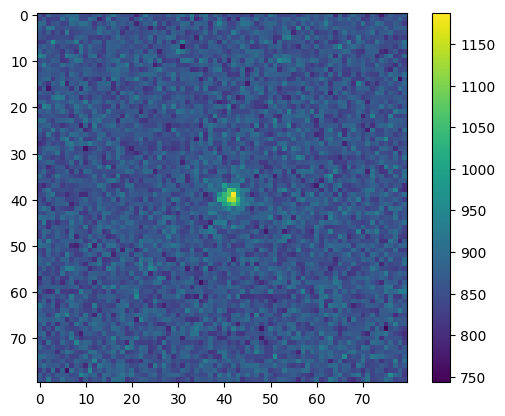

In [47]:
plt.imshow(image[8, 2].numpy())
plt.colorbar()

In [48]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated() / 1e9

0.523342848

In [49]:
batch = {"images": image.cuda(), "background": background.cuda()}
est_cat, pred = encoder.predict_step(batch, 0, 0).values()

In [50]:
est_cat.n_sources.sum(1).sum(1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

tensor(0.7852)

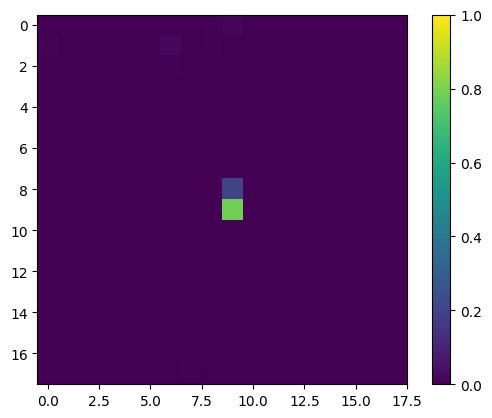

In [51]:
on_prob = pred["on_prob"].probs[:, :, :, 1].cpu()
on_prob = on_prob.view(loc_grid_size, loc_replicates, 18, 18).mean(1)[0]
plt.imshow(on_prob, vmin=0, vmax=1)
plt.colorbar()
on_prob.max()

In [52]:
joint_cats = encoder.sample(batch)

In [53]:
marginal_cats = encoder.sample(batch, cat_type="marginal")

In [54]:
joint_cats["n_sources"].sum(1).sum(1)[:20]

tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1],
       device='cuda:0')

In [55]:
marginal_cats["n_sources"].sum(1).sum(1)[:20]

tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2],
       device='cuda:0')

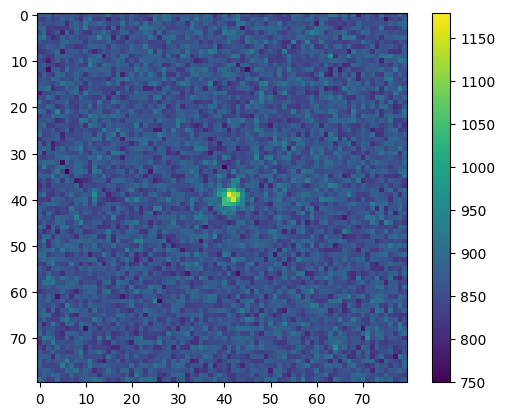

In [56]:
plt.imshow(image[2, 2].cpu())
plt.colorbar()

## An ambiguous detection (~80% detection prob) at the border and at the center

### Generate a true catalog, backgrounds, and images

In [57]:
# because there are 4 pixels in a tile column, these stars appear in the same offsets
# within pixels
loc_grid_size = 4
loc_replicates = 100
n = loc_grid_size * loc_replicates
n_sources = torch.zeros(n, 20, 20, dtype=torch.long)
n_sources[:, 10, 10] = 1
locs = torch.arange(loc_grid_size) / loc_grid_size + 0.0
locs = torch.stack([locs, torch.ones(loc_grid_size) * 0.5], dim=1)
locs = locs.view(loc_grid_size, 1, 1, 1, 1, 2).expand([-1, loc_replicates, 20, 20, 1, -1])
locs = locs.reshape(n, 20, 20, 1, 2)
true_catalog_dict = {
    "n_sources": n_sources,
    "source_type": torch.zeros(n, 20, 20, 1, 1, dtype=torch.long),
    "locs": locs,
    # with flux of 1.5, stars at all positions are detected easily (prob > 0.97 for leftmost, 1. for rest)
    # with flux of 0.3, stars at no position are detected (prob < 0.25 for all)
    # with flux of 0.5, stars at all positions are detected with prob in [0.7, 0.8]
    "star_fluxes": torch.ones(n, 20, 20, 1, 5) * 0.5,
    "galaxy_fluxes": torch.ones(n, 20, 20, 1, 5),
}
true_catalog = TileCatalog(4, true_catalog_dict)


In [58]:
rcfs, rcf_indices = simulator.randomized_image_ids(true_catalog.n_sources.size(0))
image, background, _, _ = simulator.simulate_image(true_catalog, rcfs, rcf_indices)

### Make predictions with independent tiling

In [59]:
batch = {"images": image.cuda(), "background": background.cuda()}
x_cat_marginal, x_features = encoder.get_marginal(batch)
pred_marginal = encoder.get_predicted_dist(x_cat_marginal)

It looks like the expected light source count is similar regardless of light source possition

In [60]:
reps = pred_marginal["on_prob"].probs[:, 8:11, 9, 1].sum(1).view(loc_grid_size, loc_replicates)
reps.mean(1), (reps.var(1) / loc_replicates).sqrt()

(tensor([0.7278, 0.7560, 0.8208, 0.7957], device='cuda:0'),
 tensor([0.0272, 0.0306, 0.0291, 0.0288], device='cuda:0'))

### Make predictions with dependent tiling

In [62]:
running_mean = torch.zeros(loc_grid_size).cuda()
running_var = torch.zeros(loc_grid_size).cuda()

for i in range(100):
    marginal_detections = pred_marginal["on_prob"].sample()
    # must pad because encoder.tiles_to_crop = 1
    padded_detections = torch.nn.functional.pad(marginal_detections, [1, 1, 1, 1])
    preds = encoder.get_conditional(x_cat_marginal, x_features, padded_detections)
    conditional_detections = preds["conditional"]["on_prob"].sample()
    reps = conditional_detections[:, 8:10, 9].sum(1).view(loc_grid_size, loc_replicates).float()
    running_mean += reps.mean(1)
    running_var += reps.var(1)

In [63]:
running_mean / 100, (running_var / (loc_replicates * 100)).sqrt()

(tensor([0.8572, 0.8078, 0.8173, 0.7643], device='cuda:0'),
 tensor([0.0659, 0.0508, 0.0398, 0.0432], device='cuda:0'))

In [64]:
marginal_detections[:150, 8:10, 9].float().mean(0)

tensor([0.2333, 0.5067], device='cuda:0')

In [65]:
preds = encoder.get_conditional(x_cat_marginal, x_features, torch.ones_like(padded_detections))
conditional_detections = preds["conditional"]["on_prob"].sample()
conditional_detections[:150, 8:10, 9].float().mean(0)

tensor([0., 0.], device='cuda:0')

In [66]:
preds = encoder.get_conditional(x_cat_marginal, x_features, torch.zeros_like(padded_detections))
conditional_detections = preds["conditional"]["on_prob"].sample()
conditional_detections[:150, 8:10, 9].float().mean(0)

tensor([0.6067, 0.8133], device='cuda:0')